In [ ]:
import math
import numpy as np
import pandas as pd
import glob
import os
import pickle

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras.regularizers import *
from tensorflow.keras.optimizers import Adagrad, Adam, Adamax, Nadam, Optimizer, RMSprop, SGD, schedules 
from keras.models import Sequential, Model
from keras.layers import ConvLSTM2D, Conv3D, Conv2D, Conv1D, LSTM, Dense, TimeDistributed, Input, Dropout, Activation, Flatten, BatchNormalization, Masking
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import jaccard_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import class_weight

from enum import Enum 
import random as rn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load('/content/drive/MyDrive/google_colab_skeleton/submodel/X_train.npy') 
X_val = np.load('/content/drive/MyDrive/google_colab_skeleton/submodel/X_val.npy') 
y_train = np.load('/content/drive/MyDrive/google_colab_skeleton/submodel/y_train.npy') 
y_val = np.load('/content/drive/MyDrive/google_colab_skeleton/submodel/y_val.npy') 

In [ ]:
main_model_path = '/content/drive/MyDrive/google_colab_skeleton/submodel/bestmodel1.ckpt'
main_model = tf.keras.models.load_model(main_model_path)

y_pred_main = main_model.predict(X_test)
y_pred_main_argmax = np.argmax(y_pred_main, axis = 1)
y_test_main_argmax = np.argmax(np.array(y_test), axis = 1)
print(classification_report(y_test_main_argmax, y_pred_main_argmax))

              precision    recall  f1-score   support

           0       0.61      0.94      0.74        18
           1       1.00      0.38      0.55        16
           2       1.00      1.00      1.00        25
           3       0.96      1.00      0.98        26
           4       1.00      0.96      0.98        23

    accuracy                           0.89       108
   macro avg       0.91      0.86      0.85       108
weighted avg       0.93      0.89      0.88       108



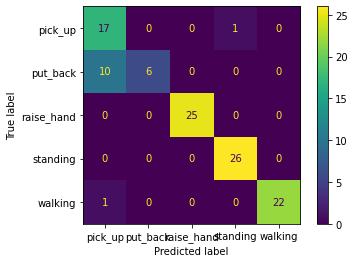

In [ ]:
cm_main = confusion_matrix(y_test_main_argmax, y_pred_main_argmax)
disp_main = ConfusionMatrixDisplay(confusion_matrix = cm_main, display_labels = ['pick_up', 'put_back', 'raise_hand', 'standing', 'walking'])
disp_main.plot() 

In [ ]:
sub_index = []
for index, prediction in enumerate(y_pred_main_argmax):
  if prediction == 0 or prediction == 1:
    sub_index.append(index)

In [ ]:
X_test_sub = []
for index in sub_index:
  X_test_sub.append(X_test[index,:,:,:,:])

X_test_sub = np.array(X_test_sub)

In [ ]:
padded_X_test_sub = X_test_sub[:,:,:,:,0:4].reshape(34, 289, 18, 4)
featured_X_test_sub = X_test_sub[:,:,:,:,4:8]

In [ ]:
def angle_features(X):
  F_ANG = []
  for s in range(len(X)):
    sample = X[s,:,:,:,]
    F_ANG_sample = []

    
    for t in range(len(sample)):
      frame = sample[t,:,:]

      # Let- ϴ is the angle AOB: A, O, B are keypoints; A = (ax, ay), B = (bx, by), and O = (ox, oy)
      # ϴ = tan^(-1) ( ((ax-ox)*(by-oy)+(ay-oy)*(bx-ox)) / ((ax-ox)*(bx-ox)-(ay-oy)*(by-oy)) )
      # for ϴ1-----keypoints: 9,3,4
      # for ϴ2-----keypoints: 3,4,5
      # for ϴ3-----keypoints: 6,7,8
      # for ϴ4-----keypoints: 12,6,7
      # for ϴ5-----keypoints: 12,9,10 
      # for ϴ6-----keypoints: 9,12,13
      # for ϴ7-----keypoints: 9,10,11
      # for ϴ8-----keypoints: 12,13,14
    
      keypoints = [[9,3,4], [3,4,5], [6,7,8], [12,6,7], [12,9,10], [9,12,13], [9,10,11], [12,13,14]]
      F_ANG_frame = []
        
      for k in keypoints:
        F_angles = []
        d = ((frame[k[0],1]-frame[k[1],1])*(frame[k[2],1]-frame[k[1],1]) -
                                    (frame[k[0],2]-frame[k[1],2])*(frame[k[2],2]-frame[k[1],2]))
        
        ϴ = math.degrees(math.atan( 
            ((frame[k[0],1]-frame[k[1],1])*(frame[k[2],2]-frame[k[1],2])        
             +(frame[k[0],2]-frame[k[1],2])*(frame[k[2],1]-frame[k[1],1])
                                   ) 
                                   / (d + 0.0000001) ))
        ϴ = ϴ / 180
        F_angles.append(ϴ)

        F_ANG_frame.append(F_angles)      
      F_ANG_sample.append(F_ANG_frame)
    F_ANG.append(F_ANG_sample)
  return np.array(F_ANG)

    

In [ ]:
featured_X_test_sub = featured_X_test_sub.reshape(34, 289, 72)
F_ANG_test_sub = angle_features(padded_X_test_sub).reshape(34, 289, 8)
X_test_sub = np.concatenate((F_ANG_test_sub, featured_X_test_sub), axis = 2)

In [ ]:
sub_model_path = '/content/drive/MyDrive/google_colab_skeleton/submodel/80f_lstm_filters400_dropout0.9_densedrop0.9_8ch_lr_sch/bestmodel2nd'
sub_model = tf.keras.models.load_model(sub_model_path)

In [ ]:
y_pred_sub = sub_model.predict(X_test_sub)
y_pred_sub_argmax = np.argmax(y_pred_sub, axis = 1)

In [ ]:
y_pred_combined_argmax = y_pred_main_argmax

In [ ]:
for index, sub in enumerate(sub_index):
  y_pred_combined_argmax[sub] = y_pred_sub_argmax[index]


In [ ]:
print(classification_report(y_test_main_argmax, y_pred_combined_argmax))

              precision    recall  f1-score   support

           0       0.64      0.89      0.74        18
           1       0.89      0.50      0.64        16
           2       1.00      1.00      1.00        25
           3       0.96      1.00      0.98        26
           4       1.00      0.96      0.98        23

    accuracy                           0.90       108
   macro avg       0.90      0.87      0.87       108
weighted avg       0.91      0.90      0.89       108



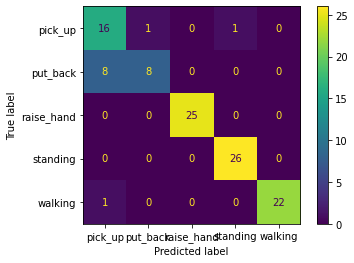

In [ ]:
cm_combined = confusion_matrix(y_test_main_argmax, y_pred_combined_argmax)
disp_combined = ConfusionMatrixDisplay(confusion_matrix = cm_combined, display_labels = ['pick_up', 'put_back', 'raise_hand', 'standing', 'walking'])
disp_combined.plot()